In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# import wti data
wti = pd.read_csv('../data/wti_prices.csv', parse_dates=['Date'])
wti['log_return'] = np.log(wti['WTI_price'] / wti['WTI_price'].shift(1))

# drop the first row
wti = wti.dropna().reset_index(drop=True)
wti.head()

,Date,WTI_price,log_return
0,1986-02-01,15.46,-0.394190
1,1986-03-01,12.61,-0.203766
2,1986-04-01,12.84,0.018075
3,1986-05-01,15.38,0.180503
4,1986-06-01,13.43,-0.135577


In [3]:
# training, validation, and test sets by 70/15/15
train_size = int(len(wti) * 0.7)
val_size = int(len(wti) * 0.15)

train_df = wti.iloc[:train_size].copy()
val_df   = wti.iloc[train_size:train_size + val_size].copy()
test_df  = wti.iloc[train_size + val_size:].copy()

# check size of each set
print(f'Training set size: {len(train_df)}')
print(f'Validation set size: {len(val_df)}')
print(f'Test set size: {len(test_df)}')

Training set size: 336
Validation set size: 72
Test set size: 72


Text(0.5, 0, 'Log Return')

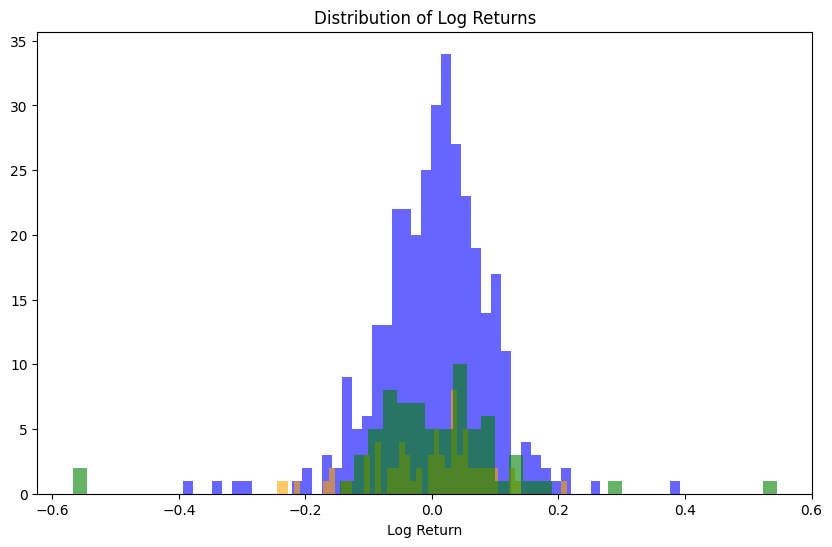

In [4]:
# plot distribution of log returns
plt.figure(figsize=(10, 6))
plt.hist(train_df['log_return'], bins=50, alpha=0.6, color='blue', label='Train')
plt.hist(val_df['log_return'], bins=50, alpha=0.6, color='orange', label='Validation')
plt.hist(test_df['log_return'], bins=50, alpha=0.6, color='green', label='Test')    
plt.title('Distribution of Log Returns')
plt.xlabel('Log Return')

# Full training set

In [5]:
# Build LSTM model using full training set
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df[["log_return"]].values)
val_scaled   = scaler.transform(val_df[["log_return"]].values)
test_scaled  = scaler.transform(test_df[["log_return"]].values)

def create_sequences(data, lookback, horizon):

    X, y = [], []
    for t in range(lookback, len(data) - horizon + 1):
        X.append(data[t - lookback:t, :])
        y.append(data[t + horizon - 1, 0])
    return np.array(X), np.array(y)



In [6]:
# baseline model parameters based on Ly et al. (2021)
base_lookback = 10
base_dropout = 0.1
base_units = 50
base_epoch = 50
base_batch_size = 32

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [13]:
tf.random.set_seed(42)
def build_model(base_lookback, base_units, base_dropout, lr=0.001):
    model = Sequential([
        LSTM(base_units, input_shape=(base_lookback, 1), return_sequences=True),
        Dropout(base_dropout),
        LSTM(base_units // 2),
        Dropout(base_dropout),
        Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="mse"
    )
    
    return model

In [23]:
# Greid search over lookback periods

lookback_options = [1, 2, 4, 6, 8, 10]

results = []

for lb in lookback_options:
    
    model = build_model(lb, base_units, base_dropout)
    
    X_train, y_train = create_sequences(train_scaled, lb, horizon=1)
    X_val, y_val     = create_sequences(val_scaled, lb, horizon=1)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=base_epoch,
        batch_size=base_batch_size,
        verbose=1
    )
    
    val_loss = min(history.history['val_loss'])
    train_loss = min(history.history['loss'])
    
    results.append({
        "lookback": lb,
        "units": base_units,
        "dropout": base_dropout,
        "epochs": base_epoch,
        "batch_size": base_batch_size,
        "train_loss": train_loss,
        "val_loss": val_loss
    })


Epoch 1/50
11/11 [==============================] - 2s 40ms/step - loss: 0.9412 - val_loss: 1.0879
Epoch 2/50
11/11 [==============================] - 0s 3ms/step - loss: 0.9326 - val_loss: 1.0780
Epoch 3/50
11/11 [==============================] - 0s 3ms/step - loss: 0.9262 - val_loss: 1.0703
Epoch 4/50
11/11 [==============================] - 0s 3ms/step - loss: 0.9182 - val_loss: 1.0624
Epoch 5/50
11/11 [==============================] - 0s 3ms/step - loss: 0.9126 - val_loss: 1.0523
Epoch 6/50
11/11 [==============================] - 0s 3ms/step - loss: 0.9048 - val_loss: 1.0431
Epoch 7/50
11/11 [==============================] - 0s 3ms/step - loss: 0.8981 - val_loss: 1.0270
Epoch 8/50
11/11 [==============================] - 0s 3ms/step - loss: 0.8912 - val_loss: 1.0147
Epoch 9/50
11/11 [==============================] - 0s 3ms/step - loss: 0.8822 - val_loss: 1.0073
Epoch 10/50
11/11 [==============================] - 0s 3ms/step - loss: 0.8766 - val_loss: 1.0014
Epoch 11/50
11/11 

In [24]:
results_df = pd.DataFrame(results)
print(results_df)

   lookback  units  dropout  epochs  batch_size  train_loss  val_loss
0         1     50      0.1      50          32    0.859818  0.983385
1         2     50      0.1      50          32    0.858937  1.012059
2         4     50      0.1      50          32    0.831201  1.037196
3         6     50      0.1      50          32    0.736293  1.171580
4         8     50      0.1      50          32    0.733042  1.160842
5        10     50      0.1      50          32    0.724321  1.150646


In [25]:
# Greed search over dropout rates
lookback = 1
drop_out_options = [0.0,0.001, 0.01, 0.03, 0.1, 0.3]

for do in drop_out_options:
    
    model = build_model(lookback, base_units, do)
    
    X_train, y_train = create_sequences(train_scaled, lookback, horizon=1)
    X_val, y_val     = create_sequences(val_scaled, lookback, horizon=1)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=base_epoch,
        batch_size=base_batch_size,
        verbose=1
    )
    
    val_loss = min(history.history['val_loss'])
    train_loss = min(history.history['loss'])
    
    results.append({
        "lookback": lookback,
        "units": base_units,
        "dropout": do,
        "epochs": base_epoch,
        "batch_size": base_batch_size,
        "train_loss": train_loss,
        "val_loss": val_loss
    })

Epoch 1/50
11/11 [==============================] - 2s 66ms/step - loss: 0.9284 - val_loss: 1.0710
Epoch 2/50
11/11 [==============================] - 0s 3ms/step - loss: 0.9195 - val_loss: 1.0575
Epoch 3/50
11/11 [==============================] - 0s 3ms/step - loss: 0.9103 - val_loss: 1.0475
Epoch 4/50
11/11 [==============================] - 0s 5ms/step - loss: 0.9015 - val_loss: 1.0382
Epoch 5/50
11/11 [==============================] - 0s 4ms/step - loss: 0.8946 - val_loss: 1.0270
Epoch 6/50
11/11 [==============================] - 0s 3ms/step - loss: 0.8877 - val_loss: 1.0190
Epoch 7/50
11/11 [==============================] - 0s 3ms/step - loss: 0.8819 - val_loss: 1.0050
Epoch 8/50
11/11 [==============================] - 0s 3ms/step - loss: 0.8762 - val_loss: 0.9966
Epoch 9/50
11/11 [==============================] - 0s 3ms/step - loss: 0.8738 - val_loss: 0.9944
Epoch 10/50
11/11 [==============================] - 0s 3ms/step - loss: 0.8725 - val_loss: 0.9935
Epoch 11/50
11/11 

In [26]:
results_df = pd.DataFrame(results)
print(results_df)

    lookback  units  dropout  epochs  batch_size  train_loss  val_loss
0          1     50    0.100      50          32    0.859818  0.983385
1          2     50    0.100      50          32    0.858937  1.012059
2          4     50    0.100      50          32    0.831201  1.037196
3          6     50    0.100      50          32    0.736293  1.171580
4          8     50    0.100      50          32    0.733042  1.160842
5         10     50    0.100      50          32    0.724321  1.150646
6          1     50    0.000      50          32    0.862595  0.983056
7          1     50    0.001      50          32    0.863284  0.983592
8          1     50    0.010      50          32    0.861298  0.983548
9          1     50    0.030      50          32    0.859406  0.983602
10         1     50    0.100      50          32    0.857255  0.983158
11         1     50    0.300      50          32    0.854577  0.984964


In [27]:
# Greed search over number of units
units_options = [10, 50, 90, 130, 170]
drop_out = 0.0

for units in units_options:
    model = build_model(lookback, units, drop_out)
    
    X_train, y_train = create_sequences(train_scaled, lookback, horizon=1)
    X_val, y_val     = create_sequences(val_scaled, lookback, horizon=1)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=base_epoch,
        batch_size=base_batch_size,
        verbose=1
    )
    
    val_loss = min(history.history['val_loss'])
    train_loss = min(history.history['loss'])
    
    results.append({
        "lookback": lookback,
        "units": units,
        "dropout": drop_out,
        "epochs": base_epoch,
        "batch_size": base_batch_size,
        "train_loss": train_loss,
        "val_loss": val_loss
    })

Epoch 1/50
11/11 [==============================] - 2s 70ms/step - loss: 0.9390 - val_loss: 1.0907
Epoch 2/50
11/11 [==============================] - 0s 3ms/step - loss: 0.9371 - val_loss: 1.0879
Epoch 3/50
11/11 [==============================] - 0s 3ms/step - loss: 0.9353 - val_loss: 1.0862
Epoch 4/50
11/11 [==============================] - 0s 3ms/step - loss: 0.9334 - val_loss: 1.0843
Epoch 5/50
11/11 [==============================] - 0s 3ms/step - loss: 0.9319 - val_loss: 1.0821
Epoch 6/50
11/11 [==============================] - 0s 3ms/step - loss: 0.9304 - val_loss: 1.0806
Epoch 7/50
11/11 [==============================] - 0s 3ms/step - loss: 0.9285 - val_loss: 1.0767
Epoch 8/50
11/11 [==============================] - 0s 3ms/step - loss: 0.9264 - val_loss: 1.0735
Epoch 9/50
11/11 [==============================] - 0s 3ms/step - loss: 0.9246 - val_loss: 1.0711
Epoch 10/50
11/11 [==============================] - 0s 3ms/step - loss: 0.9228 - val_loss: 1.0684
Epoch 11/50
11/11 

In [28]:
results_df = pd.DataFrame(results)
print(results_df)

    lookback  units  dropout  epochs  batch_size  train_loss  val_loss
0          1     50    0.100      50          32    0.859818  0.983385
1          2     50    0.100      50          32    0.858937  1.012059
2          4     50    0.100      50          32    0.831201  1.037196
3          6     50    0.100      50          32    0.736293  1.171580
4          8     50    0.100      50          32    0.733042  1.160842
5         10     50    0.100      50          32    0.724321  1.150646
6          1     50    0.000      50          32    0.862595  0.983056
7          1     50    0.001      50          32    0.863284  0.983592
8          1     50    0.010      50          32    0.861298  0.983548
9          1     50    0.030      50          32    0.859406  0.983602
10         1     50    0.100      50          32    0.857255  0.983158
11         1     50    0.300      50          32    0.854577  0.984964
12         1     10    0.000      50          32    0.878982  0.997892
13    

In [30]:
# Greed search over number of epochs
epochs_options = [20, 40, 60, 80, 100]
units = 170

for epochs in epochs_options:
    model = build_model(lookback, units, drop_out)
    
    X_train, y_train = create_sequences(train_scaled, lookback, horizon=1)
    X_val, y_val     = create_sequences(val_scaled, lookback, horizon=1)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=int(epochs),
        batch_size=base_batch_size,
        verbose=1
    )
    
    val_loss = min(history.history['val_loss'])
    train_loss = min(history.history['loss'])
    
    results.append({
        "lookback": lookback,
        "units": units,
        "dropout": drop_out,
        "epochs": epochs,
        "batch_size": base_batch_size,
        "train_loss": train_loss,
        "val_loss": val_loss
    })
    

Epoch 1/20
11/11 [==============================] - 3s 43ms/step - loss: 0.9242 - val_loss: 1.0560
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 0.9055 - val_loss: 1.0268
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.8884 - val_loss: 1.0103
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.8770 - val_loss: 1.0022
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.8730 - val_loss: 0.9944
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.8720 - val_loss: 0.9955
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.8713 - val_loss: 0.9878
Epoch 8/20
11/11 [==============================] - 0s 4ms/step - loss: 0.8711 - val_loss: 0.9858
Epoch 9/20
11/11 [==============================] - 0s 4ms/step - loss: 0.8699 - val_loss: 0.9892
Epoch 10/20
11/11 [==============================] - 0s 4ms/step - loss: 0.8678 - val_loss: 0.9917
Epoch 11/20
11/11 

In [31]:
results_df = pd.DataFrame(results)
print(results_df)

    lookback  units  dropout  epochs  batch_size  train_loss  val_loss
0          1     50    0.100      50          32    0.859818  0.983385
1          2     50    0.100      50          32    0.858937  1.012059
2          4     50    0.100      50          32    0.831201  1.037196
3          6     50    0.100      50          32    0.736293  1.171580
4          8     50    0.100      50          32    0.733042  1.160842
5         10     50    0.100      50          32    0.724321  1.150646
6          1     50    0.000      50          32    0.862595  0.983056
7          1     50    0.001      50          32    0.863284  0.983592
8          1     50    0.010      50          32    0.861298  0.983548
9          1     50    0.030      50          32    0.859406  0.983602
10         1     50    0.100      50          32    0.857255  0.983158
11         1     50    0.300      50          32    0.854577  0.984964
12         1     10    0.000      50          32    0.878982  0.997892
13    

In [33]:
# Greed search over batch size
batch_size_options = [16, 32, 64]
epochs = 80

for batch_size in batch_size_options:
    model = build_model(lookback, units, drop_out)
    
    X_train, y_train = create_sequences(train_scaled, lookback, horizon=1)
    X_val, y_val     = create_sequences(val_scaled, lookback, horizon=1)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=int(epochs),
        batch_size=int(batch_size),
        verbose=1
    )
    
    val_loss = min(history.history['val_loss'])
    train_loss = min(history.history['loss'])
    
    results.append({
        "lookback": lookback,
        "units": units,
        "dropout": drop_out,
        "epochs": epochs,
        "batch_size": batch_size,
        "train_loss": train_loss,
        "val_loss": val_loss
    })


Epoch 1/80
21/21 [==============================] - 2s 24ms/step - loss: 0.9183 - val_loss: 1.0441
Epoch 2/80
21/21 [==============================] - 0s 4ms/step - loss: 0.8960 - val_loss: 1.0068
Epoch 3/80
21/21 [==============================] - 0s 4ms/step - loss: 0.8806 - val_loss: 0.9956
Epoch 4/80
21/21 [==============================] - 0s 3ms/step - loss: 0.8735 - val_loss: 0.9950
Epoch 5/80
21/21 [==============================] - 0s 3ms/step - loss: 0.8699 - val_loss: 0.9903
Epoch 6/80
21/21 [==============================] - 0s 4ms/step - loss: 0.8721 - val_loss: 0.9987
Epoch 7/80
21/21 [==============================] - 0s 3ms/step - loss: 0.8704 - val_loss: 0.9882
Epoch 8/80
21/21 [==============================] - 0s 4ms/step - loss: 0.8683 - val_loss: 0.9895
Epoch 9/80
21/21 [==============================] - 0s 3ms/step - loss: 0.8679 - val_loss: 0.9911
Epoch 10/80
21/21 [==============================] - 0s 3ms/step - loss: 0.8662 - val_loss: 0.9889
Epoch 11/80
21/21 

In [34]:
results_df = pd.DataFrame(results)
print(results_df)

    lookback  units  dropout  epochs  batch_size  train_loss  val_loss
0          1     50    0.100      50          32    0.859818  0.983385
1          2     50    0.100      50          32    0.858937  1.012059
2          4     50    0.100      50          32    0.831201  1.037196
3          6     50    0.100      50          32    0.736293  1.171580
4          8     50    0.100      50          32    0.733042  1.160842
5         10     50    0.100      50          32    0.724321  1.150646
6          1     50    0.000      50          32    0.862595  0.983056
7          1     50    0.001      50          32    0.863284  0.983592
8          1     50    0.010      50          32    0.861298  0.983548
9          1     50    0.030      50          32    0.859406  0.983602
10         1     50    0.100      50          32    0.857255  0.983158
11         1     50    0.300      50          32    0.854577  0.984964
12         1     10    0.000      50          32    0.878982  0.997892
13    

In [69]:
# Final parameters based on grid search
final_lookback = 1
final_units = 170
final_dropout = 0.0
final_epochs = 80
final_batch_size = 64
final_lr = 1e-3 

model1 = build_model(final_lookback, final_units, final_dropout, lr=final_lr)
X_train, y_train = create_sequences(train_scaled, final_lookback, horizon=1)
X_val, y_val     = create_sequences(val_scaled, final_lookback, horizon=1)

history1 = model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=int(final_epochs),
    batch_size=int(final_batch_size),
    verbose=1
)

train_loss_best = float(np.min(history.history["loss"]))
val_loss_best   = float(np.min(history.history["val_loss"]))



Epoch 1/80
6/6 [==============================] - 2s 78ms/step - loss: 0.9324 - val_loss: 1.0683
Epoch 2/80
6/6 [==============================] - 0s 6ms/step - loss: 0.9168 - val_loss: 1.0523
Epoch 3/80
6/6 [==============================] - 0s 6ms/step - loss: 0.9048 - val_loss: 1.0350
Epoch 4/80
6/6 [==============================] - 0s 6ms/step - loss: 0.8954 - val_loss: 1.0182
Epoch 5/80
6/6 [==============================] - 0s 6ms/step - loss: 0.8822 - val_loss: 1.0109
Epoch 6/80
6/6 [==============================] - 0s 6ms/step - loss: 0.8768 - val_loss: 1.0018
Epoch 7/80
6/6 [==============================] - 0s 6ms/step - loss: 0.8731 - val_loss: 0.9927
Epoch 8/80
6/6 [==============================] - 0s 10ms/step - loss: 0.8711 - val_loss: 0.9904
Epoch 9/80
6/6 [==============================] - 0s 6ms/step - loss: 0.8717 - val_loss: 0.9895
Epoch 10/80
6/6 [==============================] - 0s 6ms/step - loss: 0.8708 - val_loss: 0.9904
Epoch 11/80
6/6 [====================

In [70]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, scaler, plot=True):

    # Predict (scaled)
    y_pred_scaled = model.predict(X_test).flatten()

    # Convert to original scale
    y_test_unscaled = scaler.inverse_transform(
        y_test.reshape(-1,1)
    ).flatten()

    y_pred_unscaled = scaler.inverse_transform(
        y_pred_scaled.reshape(-1,1)
    ).flatten()

    # Metrics (original units)
    mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
    r2 = r2_score(y_test_unscaled, y_pred_unscaled)

    print("\nOut-of-sample test performance:")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE:  {mae:.6f}")
    print(f"MSE:  {mse:.6f}")
    print(f"R²:   {r2:.6f}")

    # Plot predictions vs actual
    if plot:
        plt.figure()
        plt.plot(y_test_unscaled, label="Actual")
        plt.plot(y_pred_unscaled, label="Predicted")
        plt.title("Out-of-sample Prediction vs Actual")
        plt.legend()
        plt.show()

        # Residual plot
        residuals = y_test_unscaled - y_pred_unscaled

        plt.figure()
        plt.plot(residuals)
        plt.axhline(0)
        plt.title("Residuals")
        plt.show()

    return rmse, mae, mse, r2, y_pred_unscaled


3/3 [==============================] - 0s 1ms/step

Out-of-sample test performance:
RMSE: 0.146676
MAE:  0.082175
MSE:  0.021514
R²:   -0.133885


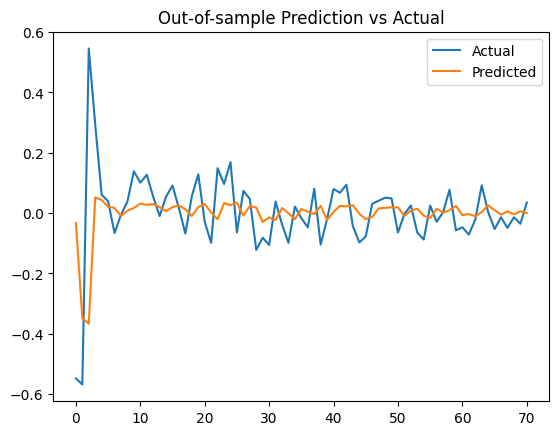

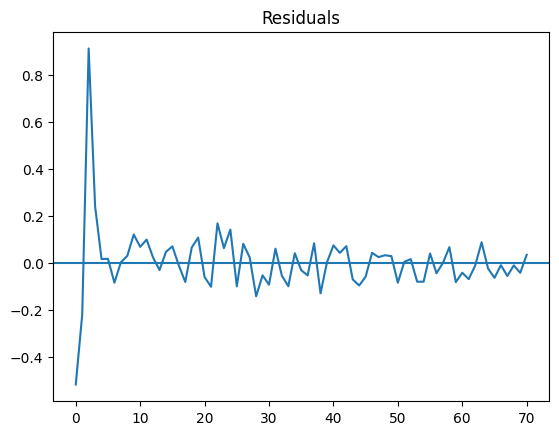

In [71]:
X_test, y_test = create_sequences(test_scaled, final_lookback, horizon=1)

rmse, mae, mse, r2, y_pred = evaluate_model(
    model1,
    X_test,
    y_test,
    scaler
)


# Halfing the training set

In [46]:
# reduce 25% the training data 
train_df2_scaled = train_scaled[len(train_scaled) // 4:]
print(len(train_df2_scaled))


252


In [47]:
# Grid search over lookback periods with reduced training data
results_reduced = []
lookback_options = [1, 2, 4, 6, 8, 10]

for lb in lookback_options:
    model = build_model(lb, base_units, base_dropout)
    
    X_train, y_train = create_sequences(train_df2_scaled, lb, horizon=1)
    X_val, y_val     = create_sequences(val_scaled, lb, horizon=1)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=base_epoch,
        batch_size=base_batch_size,
        verbose=1
    )
    
    val_loss = min(history.history['val_loss'])
    train_loss = min(history.history['loss'])
    
    results_reduced.append({
        "lookback": lb,
        "units": base_units,
        "dropout": base_dropout,
        "epochs": base_epoch,
        "batch_size": base_batch_size,
        "train_loss": train_loss,
        "val_loss": val_loss
    })

Epoch 1/50
8/8 [==============================] - 2s 56ms/step - loss: 0.8682 - val_loss: 1.0840
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8636 - val_loss: 1.0771
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8597 - val_loss: 1.0720
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8577 - val_loss: 1.0654
Epoch 5/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8534 - val_loss: 1.0599
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8487 - val_loss: 1.0555
Epoch 7/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8466 - val_loss: 1.0499
Epoch 8/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8396 - val_loss: 1.0460
Epoch 9/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8356 - val_loss: 1.0381
Epoch 10/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8336 - val_loss: 1.0291
Epoch 11/50
8/8 [=====================

In [48]:
results_reduced_df = pd.DataFrame(results_reduced)
print(results_reduced_df)

   lookback  units  dropout  epochs  batch_size  train_loss  val_loss
0         1     50      0.1      50          32    0.799973  0.987378
1         2     50      0.1      50          32    0.788157  1.062514
2         4     50      0.1      50          32    0.764385  1.064717
3         6     50      0.1      50          32    0.751964  1.166383
4         8     50      0.1      50          32    0.756122  1.151645
5        10     50      0.1      50          32    0.733005  1.129748


In [49]:
lookback = 1
drop_out_options = [0.0,0.001, 0.01, 0.03, 0.1, 0.3]

for do in drop_out_options:
    model = build_model(lookback, base_units, do)
    
    X_train, y_train = create_sequences(train_df2_scaled, lookback, horizon=1)
    X_val, y_val     = create_sequences(val_scaled, lookback, horizon=1)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=base_epoch,
        batch_size=base_batch_size,
        verbose=1
    )
    
    val_loss = min(history.history['val_loss'])
    train_loss = min(history.history['loss'])
    
    results_reduced.append({
        "lookback": lookback,
        "units": base_units,
        "dropout": do,
        "epochs": base_epoch,
        "batch_size": base_batch_size,
        "train_loss": train_loss,
        "val_loss": val_loss
    })
results_reduced_df = pd.DataFrame(results_reduced)

Epoch 1/50
8/8 [==============================] - 2s 56ms/step - loss: 0.8652 - val_loss: 1.0765
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8593 - val_loss: 1.0690
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8547 - val_loss: 1.0631
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8517 - val_loss: 1.0553
Epoch 5/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8467 - val_loss: 1.0489
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8417 - val_loss: 1.0440
Epoch 7/50
8/8 [==============================] - 0s 3ms/step - loss: 0.8382 - val_loss: 1.0377
Epoch 8/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8337 - val_loss: 1.0339
Epoch 9/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8311 - val_loss: 1.0259
Epoch 10/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8265 - val_loss: 1.0167
Epoch 11/50
8/8 [=====================

In [50]:
print(results_reduced_df)

    lookback  units  dropout  epochs  batch_size  train_loss  val_loss
0          1     50    0.100      50          32    0.799973  0.987378
1          2     50    0.100      50          32    0.788157  1.062514
2          4     50    0.100      50          32    0.764385  1.064717
3          6     50    0.100      50          32    0.751964  1.166383
4          8     50    0.100      50          32    0.756122  1.151645
5         10     50    0.100      50          32    0.733005  1.129748
6          1     50    0.000      50          32    0.805727  0.986994
7          1     50    0.001      50          32    0.805694  0.986929
8          1     50    0.010      50          32    0.804345  0.986666
9          1     50    0.030      50          32    0.802610  0.987271
10         1     50    0.100      50          32    0.801510  0.987523
11         1     50    0.300      50          32    0.799374  0.989058


In [51]:
drop_out = 0.01
units_options = [10, 50, 90, 130, 170]

for units in units_options:
    model = build_model(lookback, units, drop_out)
    
    X_train, y_train = create_sequences(train_df2_scaled, lookback, horizon=1)
    X_val, y_val     = create_sequences(val_scaled, lookback, horizon=1)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=base_epoch,
        batch_size=base_batch_size,
        verbose=1
    )
    
    val_loss = min(history.history['val_loss'])
    train_loss = min(history.history['loss'])
    
    results_reduced.append({
        "lookback": lookback,
        "units": units,
        "dropout": drop_out,
        "epochs": base_epoch,
        "batch_size": base_batch_size,
        "train_loss": train_loss,
        "val_loss": val_loss
    })
results_reduced_df = pd.DataFrame(results_reduced)

Epoch 1/50
8/8 [==============================] - 3s 67ms/step - loss: 0.8690 - val_loss: 1.0888
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8680 - val_loss: 1.0872
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8667 - val_loss: 1.0866
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8661 - val_loss: 1.0855
Epoch 5/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8657 - val_loss: 1.0846
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8647 - val_loss: 1.0841
Epoch 7/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8633 - val_loss: 1.0834
Epoch 8/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8619 - val_loss: 1.0830
Epoch 9/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8616 - val_loss: 1.0818
Epoch 10/50
8/8 [==============================] - 0s 5ms/step - loss: 0.8602 - val_loss: 1.0797
Epoch 11/50
8/8 [=====================

In [52]:
print(results_reduced_df)

    lookback  units  dropout  epochs  batch_size  train_loss  val_loss
0          1     50    0.100      50          32    0.799973  0.987378
1          2     50    0.100      50          32    0.788157  1.062514
2          4     50    0.100      50          32    0.764385  1.064717
3          6     50    0.100      50          32    0.751964  1.166383
4          8     50    0.100      50          32    0.756122  1.151645
5         10     50    0.100      50          32    0.733005  1.129748
6          1     50    0.000      50          32    0.805727  0.986994
7          1     50    0.001      50          32    0.805694  0.986929
8          1     50    0.010      50          32    0.804345  0.986666
9          1     50    0.030      50          32    0.802610  0.987271
10         1     50    0.100      50          32    0.801510  0.987523
11         1     50    0.300      50          32    0.799374  0.989058
12         1     10    0.010      50          32    0.822478  1.008227
13    

In [53]:
units = 170 
epochs_options = [20, 40, 60, 80, 100]

for epochs in epochs_options:
    model = build_model(lookback, units, drop_out)
    
    X_train, y_train = create_sequences(train_df2_scaled, lookback, horizon=1)
    X_val, y_val     = create_sequences(val_scaled, lookback, horizon=1)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=int(epochs),
        batch_size=base_batch_size,
        verbose=1
    )
    
    val_loss = min(history.history['val_loss'])
    train_loss = min(history.history['loss'])
    
    results_reduced.append({
        "lookback": lookback,
        "units": units,
        "dropout": drop_out,
        "epochs": epochs,
        "batch_size": base_batch_size,
        "train_loss": train_loss,
        "val_loss": val_loss
    })
results_reduced_df = pd.DataFrame(results_reduced)

Epoch 1/20
8/8 [==============================] - 2s 61ms/step - loss: 0.8675 - val_loss: 1.0718
Epoch 2/20
8/8 [==============================] - 0s 5ms/step - loss: 0.8539 - val_loss: 1.0546
Epoch 3/20
8/8 [==============================] - 0s 5ms/step - loss: 0.8433 - val_loss: 1.0397
Epoch 4/20
8/8 [==============================] - 0s 5ms/step - loss: 0.8388 - val_loss: 1.0219
Epoch 5/20
8/8 [==============================] - 0s 5ms/step - loss: 0.8297 - val_loss: 1.0119
Epoch 6/20
8/8 [==============================] - 0s 5ms/step - loss: 0.8226 - val_loss: 1.0080
Epoch 7/20
8/8 [==============================] - 0s 5ms/step - loss: 0.8213 - val_loss: 1.0037
Epoch 8/20
8/8 [==============================] - 0s 6ms/step - loss: 0.8208 - val_loss: 1.0045
Epoch 9/20
8/8 [==============================] - 0s 5ms/step - loss: 0.8175 - val_loss: 0.9992
Epoch 10/20
8/8 [==============================] - 0s 8ms/step - loss: 0.8155 - val_loss: 0.9930
Epoch 11/20
8/8 [=====================

In [54]:
print(results_reduced_df)

    lookback  units  dropout  epochs  batch_size  train_loss  val_loss
0          1     50    0.100      50          32    0.799973  0.987378
1          2     50    0.100      50          32    0.788157  1.062514
2          4     50    0.100      50          32    0.764385  1.064717
3          6     50    0.100      50          32    0.751964  1.166383
4          8     50    0.100      50          32    0.756122  1.151645
5         10     50    0.100      50          32    0.733005  1.129748
6          1     50    0.000      50          32    0.805727  0.986994
7          1     50    0.001      50          32    0.805694  0.986929
8          1     50    0.010      50          32    0.804345  0.986666
9          1     50    0.030      50          32    0.802610  0.987271
10         1     50    0.100      50          32    0.801510  0.987523
11         1     50    0.300      50          32    0.799374  0.989058
12         1     10    0.010      50          32    0.822478  1.008227
13    

In [55]:
epochs = 40
batch_size_options = [16, 32, 64]

for batch_size in batch_size_options:
    model = build_model(lookback, units, drop_out)
    
    X_train, y_train = create_sequences(train_df2_scaled, lookback, horizon=1)
    X_val, y_val     = create_sequences(val_scaled, lookback, horizon=1)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=int(epochs),
        batch_size=int(batch_size),
        verbose=1
    )
    
    val_loss = min(history.history['val_loss'])
    train_loss = min(history.history['loss'])
    
    results_reduced.append({
        "lookback": lookback,
        "units": units,
        "dropout": drop_out,
        "epochs": epochs,
        "batch_size": batch_size,
        "train_loss": train_loss,
        "val_loss": val_loss
    })
results_reduced_df = pd.DataFrame(results_reduced)
print(results_reduced_df)

Epoch 1/40
16/16 [==============================] - 3s 29ms/step - loss: 0.8668 - val_loss: 1.0602
Epoch 2/40
16/16 [==============================] - 0s 4ms/step - loss: 0.8439 - val_loss: 1.0297
Epoch 3/40
16/16 [==============================] - 0s 4ms/step - loss: 0.8298 - val_loss: 1.0092
Epoch 4/40
16/16 [==============================] - 0s 3ms/step - loss: 0.8305 - val_loss: 0.9951
Epoch 5/40
16/16 [==============================] - 0s 3ms/step - loss: 0.8195 - val_loss: 0.9965
Epoch 6/40
16/16 [==============================] - 0s 3ms/step - loss: 0.8197 - val_loss: 1.0028
Epoch 7/40
16/16 [==============================] - 0s 3ms/step - loss: 0.8191 - val_loss: 0.9984
Epoch 8/40
16/16 [==============================] - 0s 4ms/step - loss: 0.8197 - val_loss: 1.0025
Epoch 9/40
16/16 [==============================] - 0s 4ms/step - loss: 0.8150 - val_loss: 0.9941
Epoch 10/40
16/16 [==============================] - 0s 3ms/step - loss: 0.8131 - val_loss: 0.9864
Epoch 11/40
16/16 

In [56]:
print(results_df)

    lookback  units  dropout  epochs  batch_size  train_loss  val_loss
0          1     50    0.100      50          32    0.859818  0.983385
1          2     50    0.100      50          32    0.858937  1.012059
2          4     50    0.100      50          32    0.831201  1.037196
3          6     50    0.100      50          32    0.736293  1.171580
4          8     50    0.100      50          32    0.733042  1.160842
5         10     50    0.100      50          32    0.724321  1.150646
6          1     50    0.000      50          32    0.862595  0.983056
7          1     50    0.001      50          32    0.863284  0.983592
8          1     50    0.010      50          32    0.861298  0.983548
9          1     50    0.030      50          32    0.859406  0.983602
10         1     50    0.100      50          32    0.857255  0.983158
11         1     50    0.300      50          32    0.854577  0.984964
12         1     10    0.000      50          32    0.878982  0.997892
13    

In [57]:
final2_lookback = 1
final2_units = 170
final2_dropout = 0.01
final2_epochs = 40
final2_batch_size = 64

tf.random.set_seed(0)

model2 = build_model(final2_lookback, final2_units, final2_dropout, lr=final_lr)
X_train2, y_train2 = create_sequences(train_df2_scaled, final2_lookback, horizon=1)
X_val2, y_val2     = create_sequences(val_scaled, final2_lookback, horizon=1)
history2 = model2.fit(
    X_train2, y_train2,
    validation_data=(X_val2, y_val2),
    epochs=int(final2_epochs),
    batch_size=int(final2_batch_size),
    verbose=1
)

train_loss_reduced = float(np.min(history2.history["loss"]))
val_loss_reduced   = float(np.min(history2.history["val_loss"]))


Epoch 1/40
4/4 [==============================] - 3s 142ms/step - loss: 0.8648 - val_loss: 1.0771
Epoch 2/40
4/4 [==============================] - 0s 9ms/step - loss: 0.8575 - val_loss: 1.0646
Epoch 3/40
4/4 [==============================] - 0s 9ms/step - loss: 0.8501 - val_loss: 1.0538
Epoch 4/40
4/4 [==============================] - 0s 10ms/step - loss: 0.8425 - val_loss: 1.0453
Epoch 5/40
4/4 [==============================] - 0s 9ms/step - loss: 0.8386 - val_loss: 1.0351
Epoch 6/40
4/4 [==============================] - 0s 9ms/step - loss: 0.8324 - val_loss: 1.0263
Epoch 7/40
4/4 [==============================] - 0s 8ms/step - loss: 0.8282 - val_loss: 1.0170
Epoch 8/40
4/4 [==============================] - 0s 8ms/step - loss: 0.8232 - val_loss: 1.0090
Epoch 9/40
4/4 [==============================] - 0s 8ms/step - loss: 0.8218 - val_loss: 1.0011
Epoch 10/40
4/4 [==============================] - 0s 8ms/step - loss: 0.8194 - val_loss: 0.9966
Epoch 11/40
4/4 [===================

3/3 [==============================] - 0s 1ms/step

Out-of-sample test performance:
RMSE: 0.144610
MAE:  0.082466
MSE:  0.020912
R²:   -0.102162


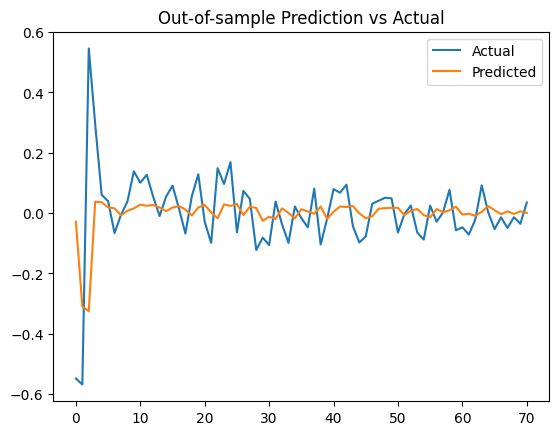

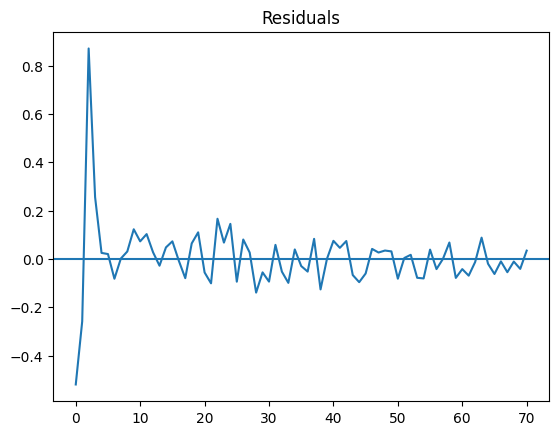

In [67]:
X_test, y_test = create_sequences(test_scaled, final2_lookback, horizon=1)

rmse2, mae2, mse2, r2_2, y_pred2 = evaluate_model(
    model2,
    X_test,
    y_test,
    scaler
)

# 50% Reduction of training data

In [75]:
# 50% reduction in training data
train_df3_scaled = train_scaled[len(train_scaled) // 2:]
print(len(train_df3_scaled))

168


In [80]:
# Grid search over lookback periods with 50% reduced training data
results_reduced3 = []
lookback_options = [1, 2, 4, 6, 8, 10]

for lb in lookback_options:
    model = build_model(lb, base_units, base_dropout)
    
    X_train, y_train = create_sequences(train_df3_scaled, lb, horizon=1)
    X_val, y_val     = create_sequences(val_scaled, lb, horizon=1)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=base_epoch,
        batch_size=base_batch_size,
        verbose=1
    )
    
    val_loss = min(history.history['val_loss'])
    train_loss = min(history.history['loss'])
    
    results_reduced3.append({
        "lookback": lb,
        "units": base_units,
        "dropout": base_dropout,
        "epochs": base_epoch,
        "batch_size": base_batch_size,
        "train_loss": train_loss,
        "val_loss": val_loss
    })
results_reduced3_df = pd.DataFrame(results_reduced3)
print(results_reduced3_df)

Epoch 1/50
6/6 [==============================] - 3s 77ms/step - loss: 0.9848 - val_loss: 1.0826
Epoch 2/50
6/6 [==============================] - 0s 4ms/step - loss: 0.9806 - val_loss: 1.0781
Epoch 3/50
6/6 [==============================] - 0s 4ms/step - loss: 0.9757 - val_loss: 1.0759
Epoch 4/50
6/6 [==============================] - 0s 5ms/step - loss: 0.9734 - val_loss: 1.0723
Epoch 5/50
6/6 [==============================] - 0s 4ms/step - loss: 0.9690 - val_loss: 1.0688
Epoch 6/50
6/6 [==============================] - 0s 5ms/step - loss: 0.9663 - val_loss: 1.0655
Epoch 7/50
6/6 [==============================] - 0s 4ms/step - loss: 0.9587 - val_loss: 1.0622
Epoch 8/50
6/6 [==============================] - 0s 4ms/step - loss: 0.9604 - val_loss: 1.0582
Epoch 9/50
6/6 [==============================] - 0s 4ms/step - loss: 0.9548 - val_loss: 1.0509
Epoch 10/50
6/6 [==============================] - 0s 4ms/step - loss: 0.9489 - val_loss: 1.0426
Epoch 11/50
6/6 [=====================

In [81]:
print(results_reduced3_df)

   lookback  units  dropout  epochs  batch_size  train_loss  val_loss
0         1     50      0.1      50          32    0.889398  0.984874
1         2     50      0.1      50          32    0.881249  1.076948
2         4     50      0.1      50          32    0.808026  1.071702
3         6     50      0.1      50          32    0.824249  1.161485
4         8     50      0.1      50          32    0.776958  1.177493
5        10     50      0.1      50          32    0.779842  1.156198


In [82]:
lookback = 1
drop_out_options = [0.0,0.001, 0.01, 0.03, 0.1, 0.3]

for do in drop_out_options:
    model = build_model(lookback, base_units, do)
    
    X_train, y_train = create_sequences(train_df3_scaled, lookback, horizon=1)
    X_val, y_val     = create_sequences(val_scaled, lookback, horizon=1)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=base_epoch,
        batch_size=base_batch_size,
        verbose=0
    )
    
    val_loss = min(history.history['val_loss'])
    train_loss = min(history.history['loss'])
    
    results_reduced3.append({
        "lookback": lookback,
        "units": base_units,
        "dropout": do,
        "epochs": base_epoch,
        "batch_size": base_batch_size,
        "train_loss": train_loss,
        "val_loss": val_loss
    })
results_reduced3_df = pd.DataFrame(results_reduced3)
print(results_reduced3_df)

    lookback  units  dropout  epochs  batch_size  train_loss  val_loss
0          1     50    0.100      50          32    0.889398  0.984874
1          2     50    0.100      50          32    0.881249  1.076948
2          4     50    0.100      50          32    0.808026  1.071702
3          6     50    0.100      50          32    0.824249  1.161485
4          8     50    0.100      50          32    0.776958  1.177493
5         10     50    0.100      50          32    0.779842  1.156198
6          1     50    0.000      50          32    0.896899  0.984105
7          1     50    0.001      50          32    0.896809  0.984059
8          1     50    0.010      50          32    0.896797  0.984851
9          1     50    0.030      50          32    0.894855  0.984039
10         1     50    0.100      50          32    0.891514  0.985041
11         1     50    0.300      50          32    0.881030  0.989725


In [83]:
drop_out = 0.03
units_options = [10, 50, 90, 130, 170]

for units in units_options:
    model = build_model(lookback, units, drop_out)
    
    X_train, y_train = create_sequences(train_df3_scaled, lookback, horizon=1)
    X_val, y_val     = create_sequences(val_scaled, lookback, horizon=1)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=base_epoch,
        batch_size=base_batch_size,
        verbose=0
    )
    
    val_loss = min(history.history['val_loss'])
    train_loss = min(history.history['loss'])
    
    results_reduced3.append({
        "lookback": lookback,
        "units": units,
        "dropout": drop_out,
        "epochs": base_epoch,
        "batch_size": base_batch_size,
        "train_loss": train_loss,
        "val_loss": val_loss
    })
results_reduced3_df = pd.DataFrame(results_reduced3)
print(results_reduced3_df)

    lookback  units  dropout  epochs  batch_size  train_loss  val_loss
0          1     50    0.100      50          32    0.889398  0.984874
1          2     50    0.100      50          32    0.881249  1.076948
2          4     50    0.100      50          32    0.808026  1.071702
3          6     50    0.100      50          32    0.824249  1.161485
4          8     50    0.100      50          32    0.776958  1.177493
5         10     50    0.100      50          32    0.779842  1.156198
6          1     50    0.000      50          32    0.896899  0.984105
7          1     50    0.001      50          32    0.896809  0.984059
8          1     50    0.010      50          32    0.896797  0.984851
9          1     50    0.030      50          32    0.894855  0.984039
10         1     50    0.100      50          32    0.891514  0.985041
11         1     50    0.300      50          32    0.881030  0.989725
12         1     10    0.030      50          32    0.928625  1.021392
13    

In [84]:
units = 90
epochs_options = [20, 40, 60, 80, 100]

for epochs in epochs_options:
    model = build_model(lookback, units, drop_out)
    
    X_train, y_train = create_sequences(train_df3_scaled, lookback, horizon=1)
    X_val, y_val     = create_sequences(val_scaled, lookback, horizon=1)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=int(epochs),
        batch_size=base_batch_size,
        verbose=0
    )
    
    val_loss = min(history.history['val_loss'])
    train_loss = min(history.history['loss'])
    
    results_reduced3.append({
        "lookback": lookback,
        "units": units,
        "dropout": drop_out,
        "epochs": epochs,
        "batch_size": base_batch_size,
        "train_loss": train_loss,
        "val_loss": val_loss
    })
results_reduced3_df = pd.DataFrame(results_reduced3)
print(results_reduced3_df)

    lookback  units  dropout  epochs  batch_size  train_loss  val_loss
0          1     50    0.100      50          32    0.889398  0.984874
1          2     50    0.100      50          32    0.881249  1.076948
2          4     50    0.100      50          32    0.808026  1.071702
3          6     50    0.100      50          32    0.824249  1.161485
4          8     50    0.100      50          32    0.776958  1.177493
5         10     50    0.100      50          32    0.779842  1.156198
6          1     50    0.000      50          32    0.896899  0.984105
7          1     50    0.001      50          32    0.896809  0.984059
8          1     50    0.010      50          32    0.896797  0.984851
9          1     50    0.030      50          32    0.894855  0.984039
10         1     50    0.100      50          32    0.891514  0.985041
11         1     50    0.300      50          32    0.881030  0.989725
12         1     10    0.030      50          32    0.928625  1.021392
13    

In [85]:
epochs = 80
batch_size_options = [16, 32, 64]

for batch_size in batch_size_options:
    model = build_model(lookback, units, drop_out)
    
    X_train, y_train = create_sequences(train_df3_scaled, lookback, horizon=1)
    X_val, y_val     = create_sequences(val_scaled, lookback, horizon=1)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=int(epochs),
        batch_size=int(batch_size),
        verbose=0
    )
    
    val_loss = min(history.history['val_loss'])
    train_loss = min(history.history['loss'])
    
    results_reduced3.append({
        "lookback": lookback,
        "units": units,
        "dropout": drop_out,
        "epochs": epochs,
        "batch_size": batch_size,
        "train_loss": train_loss,
        "val_loss": val_loss
    })
results_reduced3_df = pd.DataFrame(results_reduced3)
print(results_reduced3_df)

    lookback  units  dropout  epochs  batch_size  train_loss  val_loss
0          1     50    0.100      50          32    0.889398  0.984874
1          2     50    0.100      50          32    0.881249  1.076948
2          4     50    0.100      50          32    0.808026  1.071702
3          6     50    0.100      50          32    0.824249  1.161485
4          8     50    0.100      50          32    0.776958  1.177493
5         10     50    0.100      50          32    0.779842  1.156198
6          1     50    0.000      50          32    0.896899  0.984105
7          1     50    0.001      50          32    0.896809  0.984059
8          1     50    0.010      50          32    0.896797  0.984851
9          1     50    0.030      50          32    0.894855  0.984039
10         1     50    0.100      50          32    0.891514  0.985041
11         1     50    0.300      50          32    0.881030  0.989725
12         1     10    0.030      50          32    0.928625  1.021392
13    

In [88]:
final3_lookback = 1
final3_units = 90
final3_dropout = 0.03
final3_epochs = 80
final3_batch_size = 32

tf.random.set_seed(0)
model3 = build_model(final3_lookback, final3_units, final3_dropout, lr=final_lr)
X_train3, y_train3 = create_sequences(train_df3_scaled, final3_lookback, horizon=1)
X_val3, y_val3     = create_sequences(val_scaled, final3_lookback, horizon=1)

history3 = model3.fit(
    X_train3, y_train3,
    validation_data=(X_val3, y_val3),
    epochs=int(final3_epochs),
    batch_size=int(final3_batch_size),
    verbose=0
)
train_loss_reduced3 = float(np.min(history3.history["loss"]))
val_loss_reduced3   = float(np.min(history3.history["val_loss"]))

3/3 [==============================] - 0s 1ms/step

Out-of-sample test performance:
RMSE: 0.146037
MAE:  0.083363
MSE:  0.021327
R²:   -0.124018


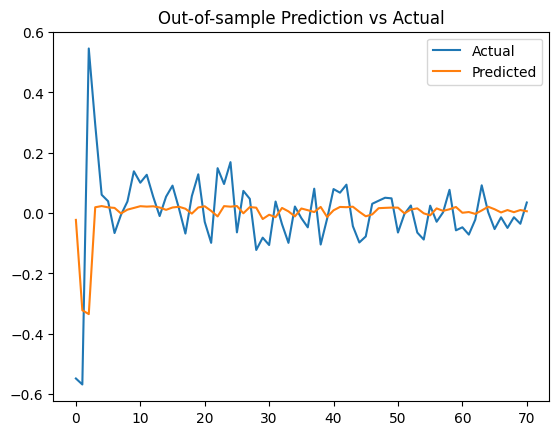

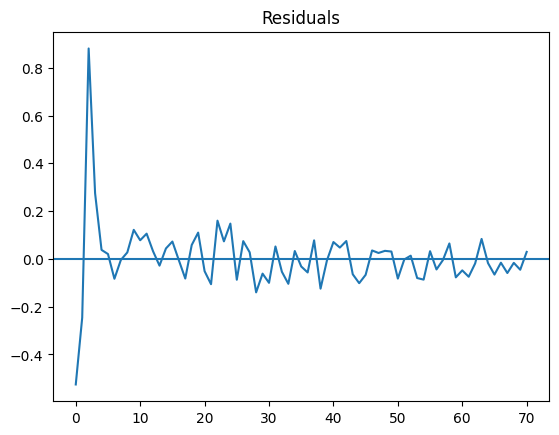

In [89]:
X_test, y_test = create_sequences(test_scaled, final3_lookback, horizon=1)

rmse3, mae3, mse3, r2_3, y_pred3 = evaluate_model(
    model3,
    X_test,
    y_test,
    scaler
)

# 75% Reduction of training data

In [92]:
# 75% reduction in training data
train_df4_scaled = train_scaled[len(train_scaled) // 4 * 3:]
print(len(train_df4_scaled))

84


In [93]:
# Grid search over lookback periods with 75% reduced training data
results_reduced4 = []

lookback_options = [1, 2, 4, 6, 8, 10]
for lb in lookback_options:
    model = build_model(lb, base_units, base_dropout)
    
    X_train, y_train = create_sequences(train_df4_scaled, lb, horizon=1)
    X_val, y_val     = create_sequences(val_scaled, lb, horizon=1)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=base_epoch,
        batch_size=base_batch_size,
        verbose=0
    )
    
    val_loss = min(history.history['val_loss'])
    train_loss = min(history.history['loss'])
    
    results_reduced4.append({
        "lookback": lb,
        "units": base_units,
        "dropout": base_dropout,
        "epochs": base_epoch,
        "batch_size": base_batch_size,
        "train_loss": train_loss,
        "val_loss": val_loss
    })
results_reduced4_df = pd.DataFrame(results_reduced4)
print(results_reduced4_df)

   lookback  units  dropout  epochs  batch_size  train_loss  val_loss
0         1     50      0.1      50          32    0.887435  0.984050
1         2     50      0.1      50          32    0.888999  1.077867
2         4     50      0.1      50          32    0.825625  1.074584
3         6     50      0.1      50          32    0.790192  1.161188
4         8     50      0.1      50          32    0.759793  1.185420
5        10     50      0.1      50          32    0.794475  1.166823


In [94]:
lookback = 1
drop_out_options = [0.0,0.001, 0.01, 0.03, 0.1, 0.3]

for do in drop_out_options:
    model = build_model(lookback, base_units, do)
    
    X_train, y_train = create_sequences(train_df4_scaled, lookback, horizon=1)
    X_val, y_val     = create_sequences(val_scaled, lookback, horizon=1)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=base_epoch,
        batch_size=base_batch_size,
        verbose=0
    )
    
    val_loss = min(history.history['val_loss'])
    train_loss = min(history.history['loss'])
    
    results_reduced4.append({
        "lookback": lookback,
        "units": base_units,
        "dropout": do,
        "epochs": base_epoch,
        "batch_size": base_batch_size,
        "train_loss": train_loss,
        "val_loss": val_loss
    })
results_reduced4_df = pd.DataFrame(results_reduced4)
print(results_reduced4_df)

    lookback  units  dropout  epochs  batch_size  train_loss  val_loss
0          1     50    0.100      50          32    0.887435  0.984050
1          2     50    0.100      50          32    0.888999  1.077867
2          4     50    0.100      50          32    0.825625  1.074584
3          6     50    0.100      50          32    0.790192  1.161188
4          8     50    0.100      50          32    0.759793  1.185420
5         10     50    0.100      50          32    0.794475  1.166823
6          1     50    0.000      50          32    0.905127  0.981888
7          1     50    0.001      50          32    0.906710  0.983517
8          1     50    0.010      50          32    0.896632  0.982739
9          1     50    0.030      50          32    0.894621  0.983688
10         1     50    0.100      50          32    0.876668  0.983814
11         1     50    0.300      50          32    0.884678  0.987847


In [95]:
drop_out = 0.0
units_options = [10, 50, 90, 130, 170]

for units in units_options:
    model = build_model(lookback, units, drop_out)
    
    X_train, y_train = create_sequences(train_df4_scaled, lookback, horizon=1)
    X_val, y_val     = create_sequences(val_scaled, lookback, horizon=1)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=base_epoch,
        batch_size=base_batch_size,
        verbose=0
    )
    
    val_loss = min(history.history['val_loss'])
    train_loss = min(history.history['loss'])
    
    results_reduced4.append({
        "lookback": lookback,
        "units": units,
        "dropout": drop_out,
        "epochs": base_epoch,
        "batch_size": base_batch_size,
        "train_loss": train_loss,
        "val_loss": val_loss
    })
results_reduced4_df = pd.DataFrame(results_reduced4)
print(results_reduced4_df)

    lookback  units  dropout  epochs  batch_size  train_loss  val_loss
0          1     50    0.100      50          32    0.887435  0.984050
1          2     50    0.100      50          32    0.888999  1.077867
2          4     50    0.100      50          32    0.825625  1.074584
3          6     50    0.100      50          32    0.790192  1.161188
4          8     50    0.100      50          32    0.759793  1.185420
5         10     50    0.100      50          32    0.794475  1.166823
6          1     50    0.000      50          32    0.905127  0.981888
7          1     50    0.001      50          32    0.906710  0.983517
8          1     50    0.010      50          32    0.896632  0.982739
9          1     50    0.030      50          32    0.894621  0.983688
10         1     50    0.100      50          32    0.876668  0.983814
11         1     50    0.300      50          32    0.884678  0.987847
12         1     10    0.000      50          32    1.020546  1.017731
13    

In [96]:
units = 50
epochs_options = [20, 40, 60, 80, 100]

for epochs in epochs_options:
    model = build_model(lookback, units, drop_out)
    
    X_train, y_train = create_sequences(train_df4_scaled, lookback, horizon=1)
    X_val, y_val     = create_sequences(val_scaled, lookback, horizon=1)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=int(epochs),
        batch_size=base_batch_size,
        verbose=0
    )
    
    val_loss = min(history.history['val_loss'])
    train_loss = min(history.history['loss'])
    
    results_reduced4.append({
        "lookback": lookback,
        "units": units,
        "dropout": drop_out,
        "epochs": epochs,
        "batch_size": base_batch_size,
        "train_loss": train_loss,
        "val_loss": val_loss
    })
results_reduced4_df = pd.DataFrame(results_reduced4)
print(results_reduced4_df)

    lookback  units  dropout  epochs  batch_size  train_loss  val_loss
0          1     50    0.100      50          32    0.887435  0.984050
1          2     50    0.100      50          32    0.888999  1.077867
2          4     50    0.100      50          32    0.825625  1.074584
3          6     50    0.100      50          32    0.790192  1.161188
4          8     50    0.100      50          32    0.759793  1.185420
5         10     50    0.100      50          32    0.794475  1.166823
6          1     50    0.000      50          32    0.905127  0.981888
7          1     50    0.001      50          32    0.906710  0.983517
8          1     50    0.010      50          32    0.896632  0.982739
9          1     50    0.030      50          32    0.894621  0.983688
10         1     50    0.100      50          32    0.876668  0.983814
11         1     50    0.300      50          32    0.884678  0.987847
12         1     10    0.000      50          32    1.020546  1.017731
13    

In [97]:
epochs = 80
batch_size_options = [16, 32, 64]

for batch_size in batch_size_options:
    model = build_model(lookback, units, drop_out)
    
    X_train, y_train = create_sequences(train_df4_scaled, lookback, horizon=1)
    X_val, y_val     = create_sequences(val_scaled, lookback, horizon=1)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=int(epochs),
        batch_size=int(batch_size),
        verbose=0
    )
    
    val_loss = min(history.history['val_loss'])
    train_loss = min(history.history['loss'])
    
    results_reduced4.append({
        "lookback": lookback,
        "units": units,
        "dropout": drop_out,
        "epochs": epochs,
        "batch_size": batch_size,
        "train_loss": train_loss,
        "val_loss": val_loss
    })

results_reduced4_df = pd.DataFrame(results_reduced4)
print(results_reduced4_df)

    lookback  units  dropout  epochs  batch_size  train_loss  val_loss
0          1     50    0.100      50          32    0.887435  0.984050
1          2     50    0.100      50          32    0.888999  1.077867
2          4     50    0.100      50          32    0.825625  1.074584
3          6     50    0.100      50          32    0.790192  1.161188
4          8     50    0.100      50          32    0.759793  1.185420
5         10     50    0.100      50          32    0.794475  1.166823
6          1     50    0.000      50          32    0.905127  0.981888
7          1     50    0.001      50          32    0.906710  0.983517
8          1     50    0.010      50          32    0.896632  0.982739
9          1     50    0.030      50          32    0.894621  0.983688
10         1     50    0.100      50          32    0.876668  0.983814
11         1     50    0.300      50          32    0.884678  0.987847
12         1     10    0.000      50          32    1.020546  1.017731
13    

In [98]:
final4_lookback = 1
final4_units = 50
final4_dropout = 0.0
final4_epochs = 80
final4_batch_size = 32

tf.random.set_seed(0)
model4 = build_model(final4_lookback, final4_units, final4_dropout, lr=final_lr)
X_train4, y_train4 = create_sequences(train_df4_scaled, final4_lookback, horizon=1)
X_val4, y_val4     = create_sequences(val_scaled, final4_lookback, horizon=1)

history4 = model4.fit(
    X_train4, y_train4,
    validation_data=(X_val4, y_val4),
    epochs=int(final4_epochs),
    batch_size=int(final4_batch_size),
    verbose=0
)
train_loss_reduced4 = float(np.min(history4.history["loss"]))
val_loss_reduced4   = float(np.min(history4.history["val_loss"]))

3/3 [==============================] - 0s 1ms/step

Out-of-sample test performance:
RMSE: 0.142645
MAE:  0.082219
MSE:  0.020348
R²:   -0.072411


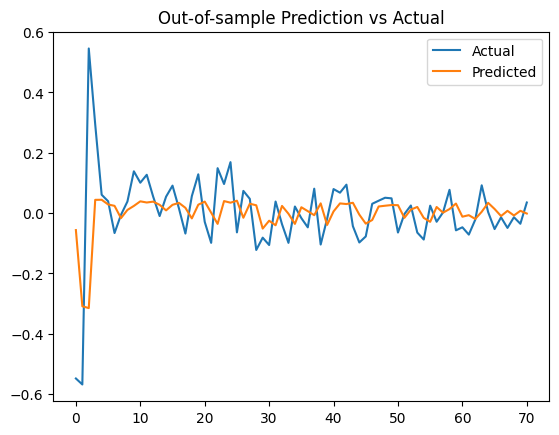

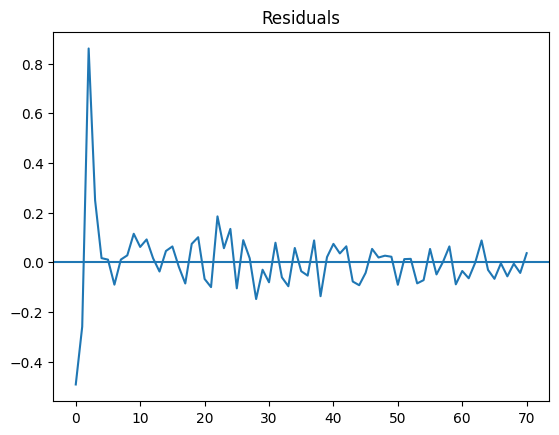

In [99]:
X_test, y_test = create_sequences(test_scaled, final4_lookback, horizon=1)
rmse4, mae4, mse4, r2_4, y_pred4 = evaluate_model(
    model4,
    X_test,
    y_test,
    scaler
)

In [100]:
# Compare results into dataframe
comparison_df = pd.DataFrame({
    "Model": ["Full Data", "25% Reduction Data", "50% Reduction Data", "75% Reduction Data"],
    "Train Loss": [train_loss_best, train_loss_reduced, train_loss_reduced3, train_loss_reduced4],
    "Val Loss": [val_loss_best, val_loss_reduced, val_loss_reduced3, val_loss_reduced4],
    "Test RMSE": [rmse, rmse2, rmse3, rmse4],
    "Test MAE": [mae, mae2, mae3, mae4],
    "Test MSE": [mse, mse2, mse3, mse4],
    "Test R²": [r2, r2_2, r2_3, r2_4]
})

print(comparison_df)


                Model  Train Loss  Val Loss  Test RMSE  Test MAE  Test MSE  \
0           Full Data    0.805939  0.986745   0.146676  0.082175  0.021514   
1  25% Reduction Data    0.805377  0.987649   0.144610  0.082466  0.020912   
2  50% Reduction Data    0.884627  0.983263   0.146037  0.083363  0.021327   
3  75% Reduction Data    0.901706  0.984338   0.142645  0.082219  0.020348   

    Test R²  
0 -0.133885  
1 -0.102162  
2 -0.124018  
3 -0.072411  


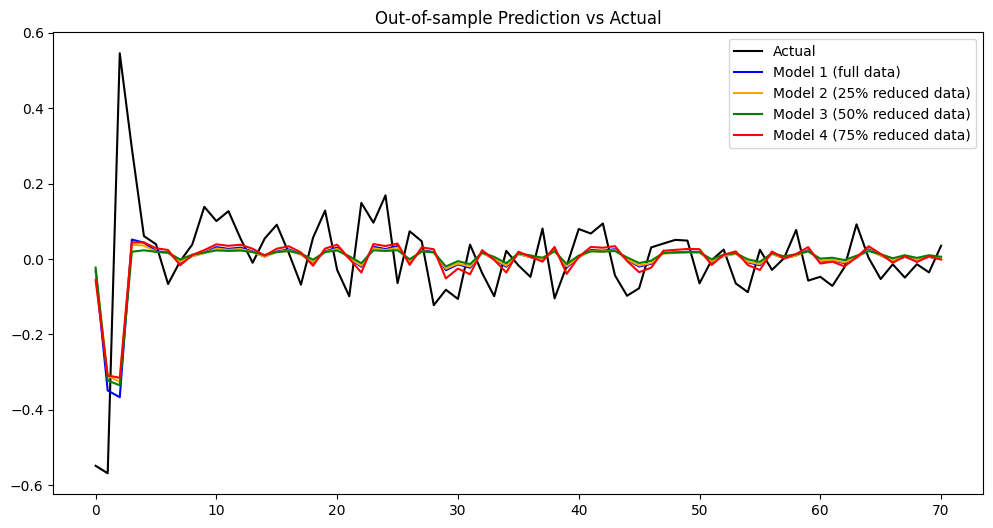

In [101]:
# plot predictions vs actual for both models
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label="Actual", color='black')
plt.plot(y_pred, label="Model 1 (full data)", color='blue')
plt.plot(y_pred2, label="Model 2 (25% reduced data)", color='orange')
plt.plot(y_pred3, label="Model 3 (50% reduced data)", color='green')
plt.plot(y_pred4, label="Model 4 (75% reduced data)", color='red')
plt.title("Out-of-sample Prediction vs Actual")
plt.legend()
plt.show()
